In [273]:
import cv2
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import alphashape

In [274]:
def sift_images(src_img, tgt_img, threshold, ratio):
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    #Threshold images
    _, src_img = cv2.threshold(src_img, threshold, 255, cv2.THRESH_BINARY)
    _, tgt_img = cv2.threshold(tgt_img, threshold, 255, cv2.THRESH_BINARY)

    # Add padding to the image
    top, bottom, left, right = 50, 50, 50, 50   
    src_img = cv2.copyMakeBorder(src_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    tgt_img = cv2.copyMakeBorder(tgt_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Detect keypoints and descriptors in both images
    keypoints1, descriptors1 = sift.detectAndCompute(src_img, None)
    keypoints2, descriptors2 = sift.detectAndCompute(tgt_img, None)

    # Match descriptors using FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to find good matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    tgt_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    src_pts = [(x,y) for [x, y] in src_pts]
    tgt_pts = [(x,y) for [x, y] in tgt_pts]

    return src_pts, tgt_pts, src_img, tgt_img

In [275]:
# Load images
src = cv2.imread('test_sequence/image2.png', cv2.IMREAD_GRAYSCALE)  # 0 for grayscale
tgt = cv2.imread('test_sequence/image1.png', cv2.IMREAD_GRAYSCALE)

In [276]:
src_pts, tgt_pts, src, tgt = sift_images(src, tgt, threshold=10, ratio=.6)

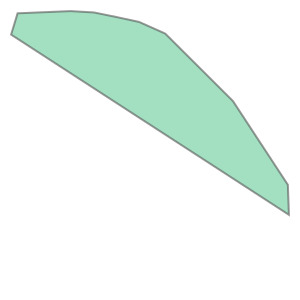

In [277]:
# Generate convex hull
alpha = 0
src_hull = alphashape.alphashape(src_pts, alpha)
tgt_hull = alphashape.alphashape(tgt_pts, alpha)
tgt_hull

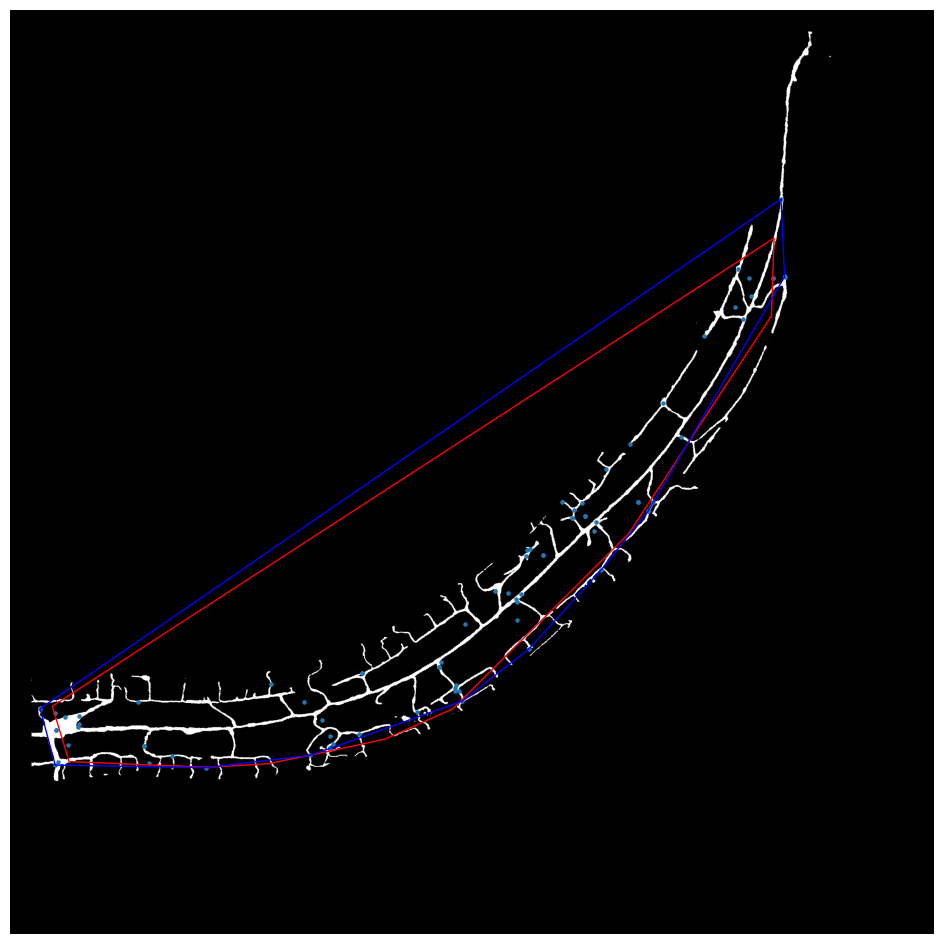

In [278]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(src, cmap='gray')
ax.scatter(*zip(*src_pts), s=5)

x_t, y_t = tgt_hull.exterior.xy
ax.fill(x_t, y_t, edgecolor='r', facecolor='none', label='target')

x_s, y_s = src_hull.exterior.xy
ax.fill(x_s, y_s, edgecolor='b', facecolor='none', label='source')

plt.axis('off')
plt.show()